In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
环境依赖检查脚本
检查是否安装以下包：
 - numpy
 - pandas
 - scikit-learn
 - scipy
 - matplotlib (可选，用于后续可视化)
 - seaborn   (可选)
输出安装状态和版本号，如果未安装则提示安装命令。
"""

import importlib.util
import subprocess
import sys

# 要检测的包及其 pip 安装名
REQUIRED_PACKAGES = {
    "numpy": "numpy",
    "pandas": "pandas",
    "sklearn": "scikit-learn",
    "scipy": "scipy",
    "matplotlib": "matplotlib",
    "seaborn": "seaborn",
}

def check_package(pkg_name, install_name=None):
    """
    检查 pkg_name 是否可导入，并打印版本；
    如果不可用，给出 pip 安装建议。
    """
    install_name = install_name or pkg_name
    spec = importlib.util.find_spec(pkg_name)
    if spec is None:
        print(f"[✗] {pkg_name} 未安装，请执行：pip install {install_name}")
    else:
        module = importlib.import_module(pkg_name)
        version = getattr(module, "__version__", "未知版本")
        print(f"[✓] {pkg_name} 已安装，版本：{version}")

def main():
    print("开始环境依赖检查...\n")
    for pkg, install_name in REQUIRED_PACKAGES.items():
        check_package(pkg, install_name)
    print("\n检查完毕。")

if __name__ == "__main__":
    main()


开始环境依赖检查...

[✓] numpy 已安装，版本：1.23.5
[✓] pandas 已安装，版本：1.5.3
[✓] sklearn 已安装，版本：1.2.1
[✓] scipy 已安装，版本：1.10.0
[✓] matplotlib 已安装，版本：3.7.0
[✓] seaborn 已安装，版本：0.12.2

检查完毕。


In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF

# === 修改这里：选择想分析的矩阵文件 ===
matrix_file = "TCGA.SBS96.all"          # 也可以换成 TCGA.SBS18.all 等
matrix_path = os.path.join("SBS", matrix_file)

assert os.path.exists(matrix_path), f"❌ 找不到 {matrix_path}"
print("✅ 找到矩阵文件 →", matrix_path)


✅ 找到矩阵文件 → SBS\TCGA.SBS96.all


In [5]:
# *.all 文件由 SigProfiler 生成，默认制表符分隔，一列 MutationType + 多列样本
V_df = pd.read_csv(matrix_path, sep="\t", index_col=0)

print("📐 原始矩阵形状：", V_df.shape)   # (突变类别数, 样本数)
display(V_df.iloc[:5, :5])              # 预览前 5×5


📐 原始矩阵形状： (96, 512)


,TCGA-05-4244,TCGA-05-4249,TCGA-05-4250,TCGA-05-4382,TCGA-05-4384
MutationType,,,,,
A[C>A]A,6,9,8,62,5
A[C>A]C,7,12,1,73,2
A[C>A]G,5,7,10,31,5
A[C>A]T,2,8,9,48,4
A[C>G]A,3,3,3,6,0


In [6]:
V = V_df.values.astype(float)

# 每个样本列除以本列总和，避免样本总突变数差异过大
V = V / V.sum(axis=0, keepdims=True)

# 验证无 NaN / Inf
assert np.isfinite(V).all(), "矩阵存在非法值"
print("✅ 归一化完成，形状：", V.shape)


✅ 归一化完成，形状： (96, 512)


In [7]:
K = 5   # 指定分解出的 signature 数量（可自行修改）

model = NMF(
    n_components=K,
    init="nndsvd",            # 快速收敛的非负 SVD 初始化
    solver="mu",              # 乘法更新
    beta_loss="kullback-leibler",
    max_iter=1000,
    random_state=42
)

W = model.fit_transform(V)    # (突变类别 × K)
H = model.components_         # (K × 样本数)

print(f"✅ NMF 完成：W{W.shape}, H{H.shape}")


✅ NMF 完成：W(96, 5), H(5, 512)


d:\anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1524: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(


In [8]:
recon = W @ H
fro_err = np.linalg.norm(V - recon, ord="fro")
print(f"🎯 Frobenius 重构误差：{fro_err:.4f}")


🎯 Frobenius 重构误差：2.3685


In [9]:
out_dir = "nmf_results"
os.makedirs(out_dir, exist_ok=True)

pd.DataFrame(W, index=V_df.index).to_csv(os.path.join(out_dir, f"W_K{K}.csv"))
pd.DataFrame(H, columns=V_df.columns).to_csv(os.path.join(out_dir, f"H_K{K}.csv"))

print(f"✅ W/H 已保存至 {out_dir}/")


✅ W/H 已保存至 nmf_results/


In [15]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF

# 抑制 sklearn NMF 警告（可选）
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    module="sklearn.decomposition._nmf"
)

# ========== 配置 ==========
matrix_file = "TCGA.SBS96.all"      # ← 改成你要分析的矩阵
matrix_path = os.path.join("SBS", matrix_file)
assert os.path.exists(matrix_path), f"找不到 {matrix_path}"

K_list = range(2, 40)               # 想更宽就改这里
max_iter = 2000                     # 适当大一点，确保每个 K 都收敛
random_state = 42
# ==========================


In [16]:
V_df = pd.read_csv(matrix_path, sep="\t", index_col=0)
V = V_df.values.astype(float)
V = V / V.sum(axis=0, keepdims=True)   # 列归一化
print("矩阵形状:", V.shape)


矩阵形状: (96, 512)


In [17]:
errors = []

for K in K_list:
    model = NMF(
        n_components=K,
        init="nndsvd",      # ↓ 想用 KL+MU 就改成 ("nndsvda", "mu", "kullback-leibler")
        solver="cd",
        max_iter=max_iter,
        random_state=random_state
    )
    W = model.fit_transform(V)
    H = model.components_
    recon = W @ H
    err = np.linalg.norm(V - recon, ord="fro")
    errors.append(err)
    print(f"K={K:2d} ▶  重构误差 = {err:.4f}")


K= 2 ▶  重构误差 = 2.6751
K= 3 ▶  重构误差 = 2.3688
K= 4 ▶  重构误差 = 2.1772
K= 5 ▶  重构误差 = 2.0491
K= 6 ▶  重构误差 = 1.9332
K= 7 ▶  重构误差 = 1.8384
K= 8 ▶  重构误差 = 1.7777
K= 9 ▶  重构误差 = 1.7340
K=10 ▶  重构误差 = 1.6881
K=11 ▶  重构误差 = 1.6436
K=12 ▶  重构误差 = 1.6049
K=13 ▶  重构误差 = 1.5693
K=14 ▶  重构误差 = 1.5293
K=15 ▶  重构误差 = 1.4958
K=16 ▶  重构误差 = 1.4624
K=17 ▶  重构误差 = 1.4332
K=18 ▶  重构误差 = 1.4047
K=19 ▶  重构误差 = 1.3752
K=20 ▶  重构误差 = 1.3491
K=21 ▶  重构误差 = 1.3130
K=22 ▶  重构误差 = 1.2892
K=23 ▶  重构误差 = 1.2626
K=24 ▶  重构误差 = 1.2342
K=25 ▶  重构误差 = 1.2075
K=26 ▶  重构误差 = 1.1837
K=27 ▶  重构误差 = 1.1579
K=28 ▶  重构误差 = 1.1353
K=29 ▶  重构误差 = 1.1124
K=30 ▶  重构误差 = 1.0861
K=31 ▶  重构误差 = 1.0645
K=32 ▶  重构误差 = 1.0459
K=33 ▶  重构误差 = 1.0238
K=34 ▶  重构误差 = 1.0041
K=35 ▶  重构误差 = 0.9867
K=36 ▶  重构误差 = 0.9673
K=37 ▶  重构误差 = 0.9476
K=38 ▶  重构误差 = 0.9291
K=39 ▶  重构误差 = 0.9115


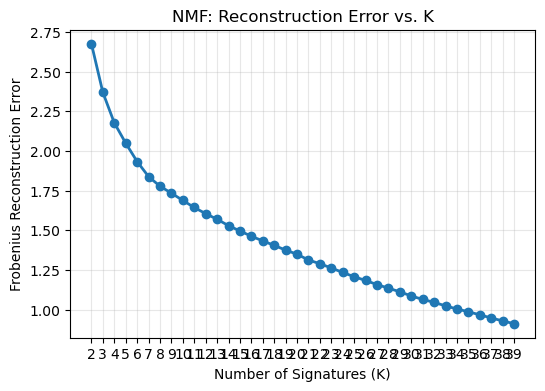

In [18]:
plt.figure(figsize=(6, 4))
plt.plot(list(K_list), errors, marker="o", linewidth=2)
plt.title("NMF: Reconstruction Error vs. K")
plt.xlabel("Number of Signatures (K)")
plt.ylabel("Frobenius Reconstruction Error")
plt.xticks(list(K_list))
plt.grid(alpha=0.3)
plt.show()


K= 2 ▶  mean=2.6751 ± 0.0000
K= 3 ▶  mean=2.3688 ± 0.0000
K= 4 ▶  mean=2.1772 ± 0.0000
K= 5 ▶  mean=2.0491 ± 0.0000
K= 6 ▶  mean=1.9332 ± 0.0000
K= 7 ▶  mean=1.8384 ± 0.0000
K= 8 ▶  mean=1.7777 ± 0.0000
K= 9 ▶  mean=1.7340 ± 0.0000
K=10 ▶  mean=1.6881 ± 0.0000
K=11 ▶  mean=1.6436 ± 0.0000
K=12 ▶  mean=1.6049 ± 0.0000
K=13 ▶  mean=1.5693 ± 0.0000
K=14 ▶  mean=1.5293 ± 0.0000
K=15 ▶  mean=1.4979 ± 0.0032
K=16 ▶  mean=1.4634 ± 0.0019
K=17 ▶  mean=1.4332 ± 0.0000
K=18 ▶  mean=1.4035 ± 0.0013
K=19 ▶  mean=1.3744 ± 0.0005
K=20 ▶  mean=1.3491 ± 0.0000
K=21 ▶  mean=1.3169 ± 0.0037
K=22 ▶  mean=1.2893 ± 0.0041
K=23 ▶  mean=1.2631 ± 0.0025
K=24 ▶  mean=1.2358 ± 0.0009
K=25 ▶  mean=1.2076 ± 0.0005
K=26 ▶  mean=1.1837 ± 0.0000
K=27 ▶  mean=1.1601 ± 0.0018
K=28 ▶  mean=1.1353 ± 0.0000
K=29 ▶  mean=1.1129 ± 0.0013
K=30 ▶  mean=1.0861 ± 0.0000
K=31 ▶  mean=1.0654 ± 0.0025
K=32 ▶  mean=1.0456 ± 0.0007
K=33 ▶  mean=1.0247 ± 0.0011
K=34 ▶  mean=1.0038 ± 0.0015
K=35 ▶  mean=0.9852 ± 0.0020
K=36 ▶  mean=0

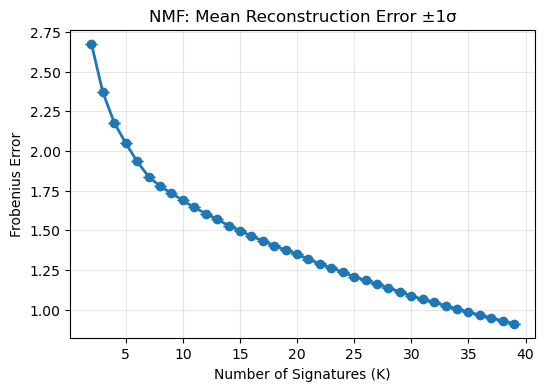

In [19]:
n_runs = 10
errors_mean, errors_std = [], []

for K in K_list:
    run_err = []
    for seed in range(n_runs):
        model = NMF(
            n_components=K,
            init="nndsvd",
            solver="cd",
            max_iter=max_iter,
            random_state=seed
        )
        W = model.fit_transform(V)
        H = model.components_
        run_err.append(np.linalg.norm(V - W @ H, ord="fro"))
    errors_mean.append(np.mean(run_err))
    errors_std.append(np.std(run_err))
    print(f"K={K:2d} ▶  mean={errors_mean[-1]:.4f} ± {errors_std[-1]:.4f}")

# 画误差 ±1σ
plt.figure(figsize=(6,4))
plt.errorbar(list(K_list), errors_mean, yerr=errors_std,
             marker="o", capsize=4, linewidth=2)
plt.title("NMF: Mean Reconstruction Error ±1σ")
plt.xlabel("Number of Signatures (K)")
plt.ylabel("Frobenius Error")
plt.grid(alpha=0.3)
plt.show()
